# PythonによるscRNA-seq解析 その2:下流解析いろいろ

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import os
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import matplotlib.pyplot as plt
import seaborn as sns

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white')

scanpy==1.9.8 anndata==0.10.5.post1 umap==0.5.5 numpy==1.26.4 scipy==1.12.0 pandas==2.2.0 scikit-learn==1.1.3 statsmodels==0.14.1 igraph==0.11.3 pynndescent==0.5.11


In [2]:
adata = sc.read_h5ad('./data/retinal.h5ad')

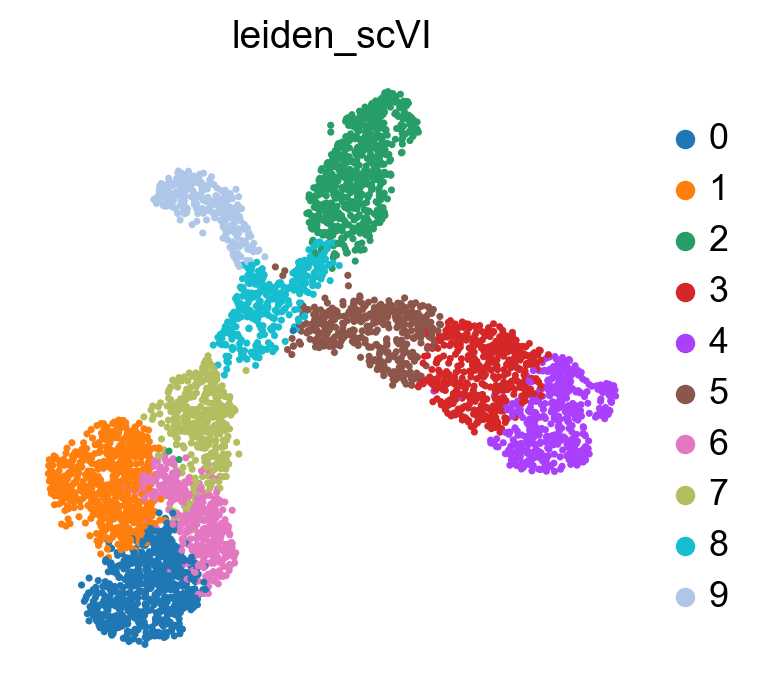

In [3]:
sc.pl.umap(adata, color=['leiden_scVI'], frameon=False)

In [4]:
adata

AnnData object with n_obs × n_vars = 4563 × 13332
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden_r0.5', '_scvi_batch', '_scvi_labels', 'leiden_scVI', 'SOLO_prediction', '_scvi_raw_norm_scaling'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'SOLO_prediction_colors', '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'dendrogram_leiden_scVI', 'hvg', 'leiden', 'leiden_r0.5_colors', 'leiden_scVI_colors', 'log1p', 'neighbors', 'pca', 'tsne', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

## Cell typeのアノテーション

### マニュアルアノテーション

先行研究・文献、研究者の経験に基づいて細胞型ごとのマーカー遺伝子をリストアップし、それらの発現量からマニュアルで各クラスタのアノテーションをつけていく方法。

クラシカルな方法で、ある種恣意的な側面もあるが、判断根拠と責任の所在がはっきりしていて安心感がある。

以下の点に注意が必要。

1. クラスタレベルのアノテーションにならざるを得ないこと（とてもじゃないが1細胞ごとにマニュアルアノテーションできない）
2. かならずしもタンパク質マーカー＝遺伝子発現マーカーとは限らないこと（できるだけトランスクリプトーム解析の結果として定義されたマーカーを使う）
3. 「特定の研究・データセット」の結果が適用できるとは限らないこと（できるだけ複数の研究で報告されている遺伝子が望ましい）

In [5]:
# 文献： https://doi.org/10.1523/JNEUROSCI.0471-20.2020 
# および、https://doi.org/10.1167/iovs.64.11.2
# より抽出した。

my_markers = {
    'Amacrine cell':['Pax6', 'Slc32a1'],
    'Horizontal cell':['Lhx1'],
    'Bipolar cell':['Vsx2', 'Samsn1'],
    'Cone cell':['Opn1sw'],
    'RGC':['Slc17a6', 'Pou4f1'],
    'Muller cell':['Slc1a3', 'Lhx2']}

Amacrine cell


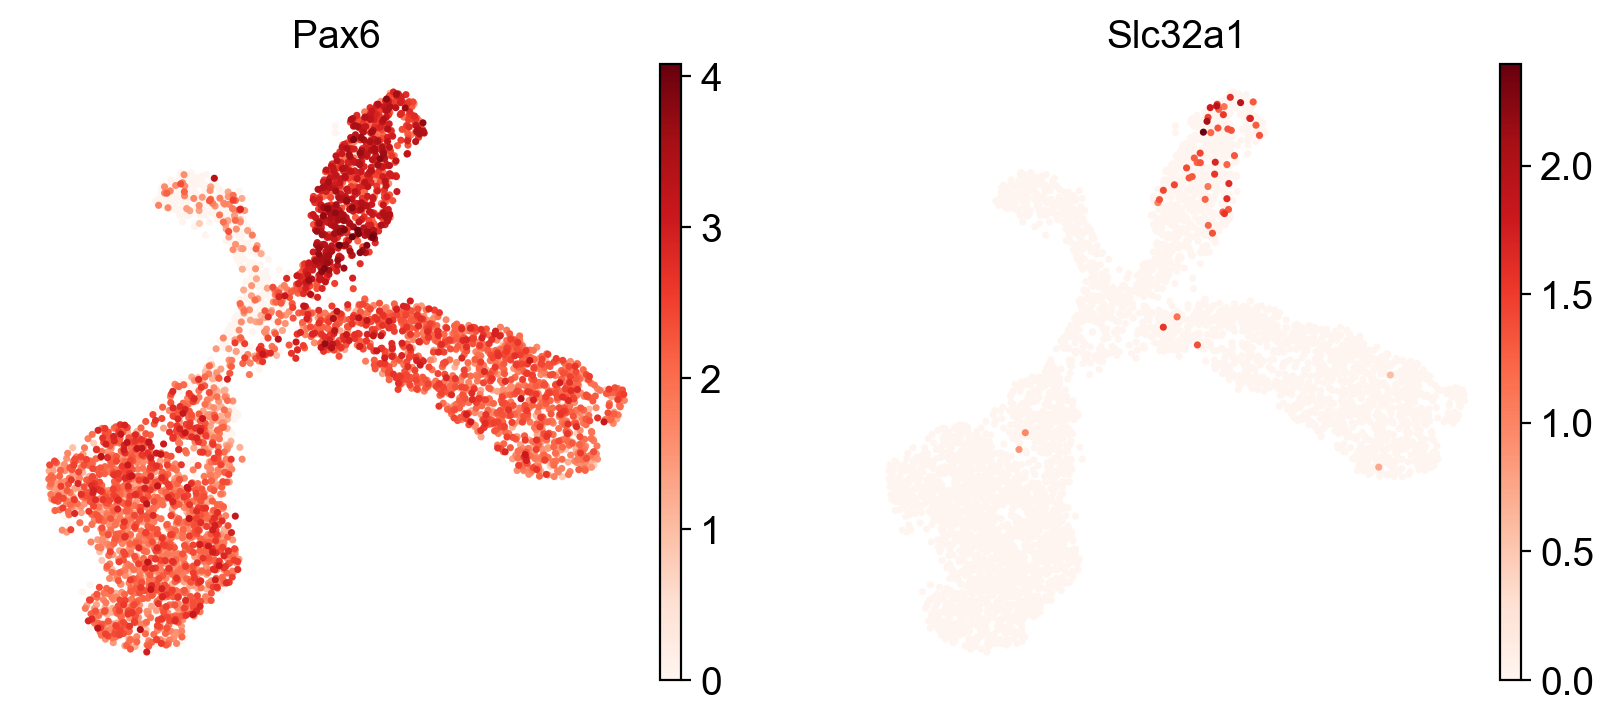

Horizontal cell


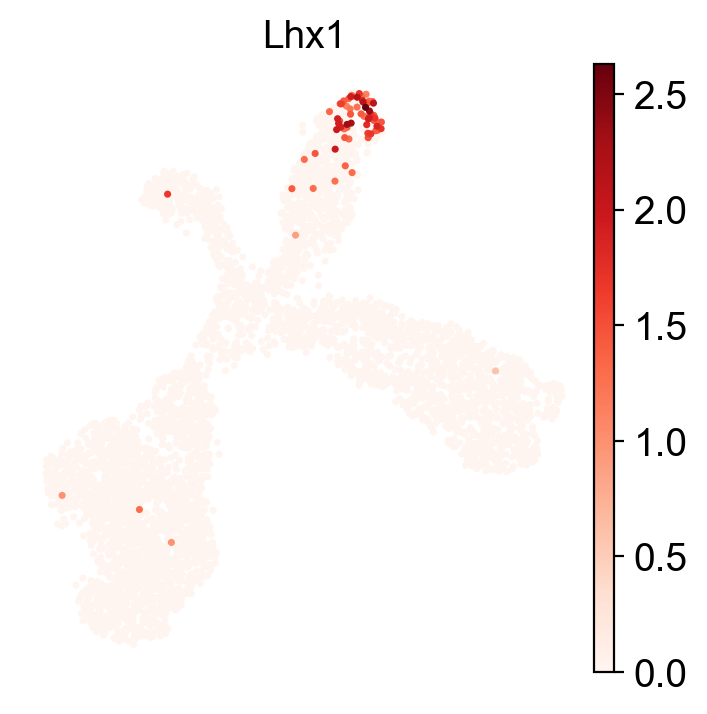

Bipolar cell


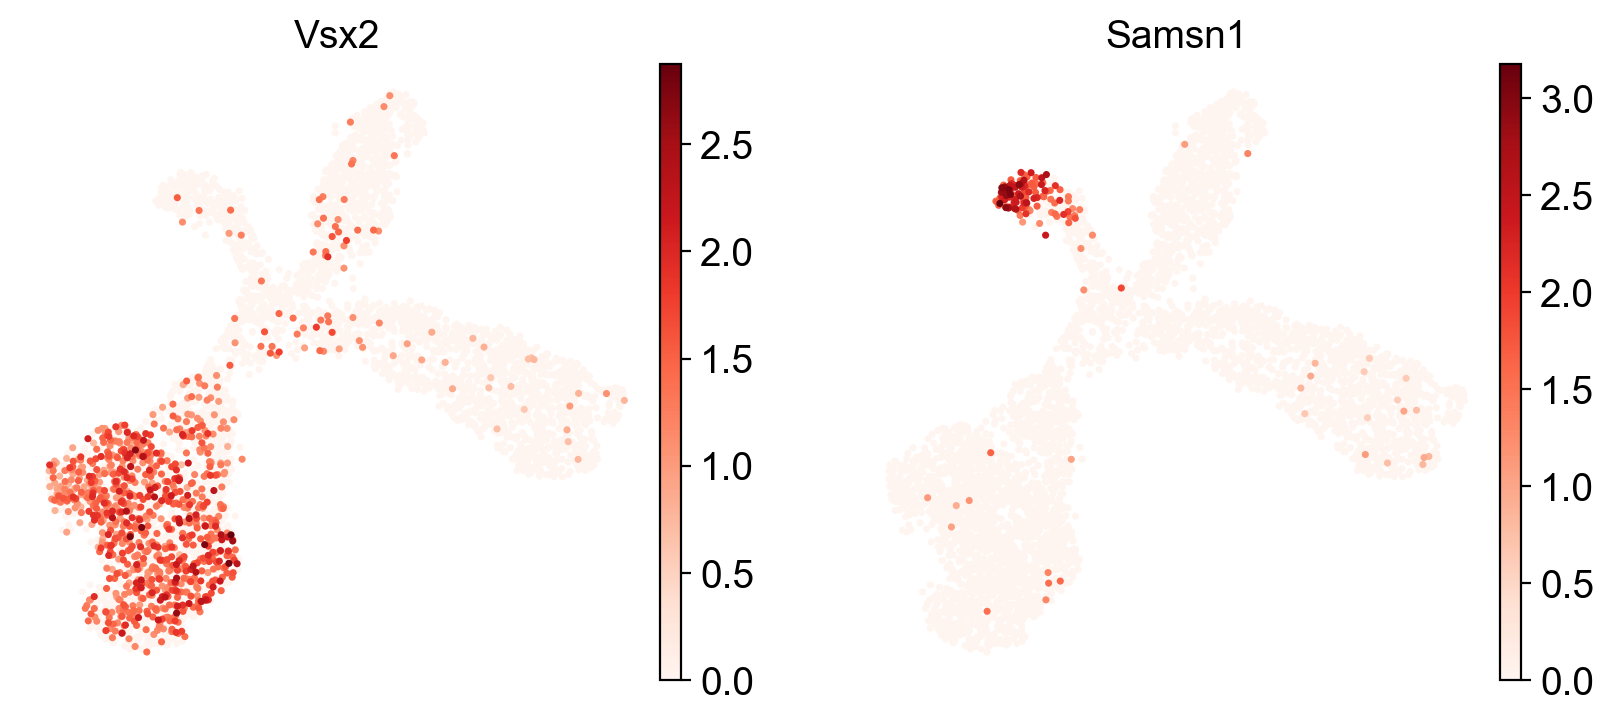

Cone cell


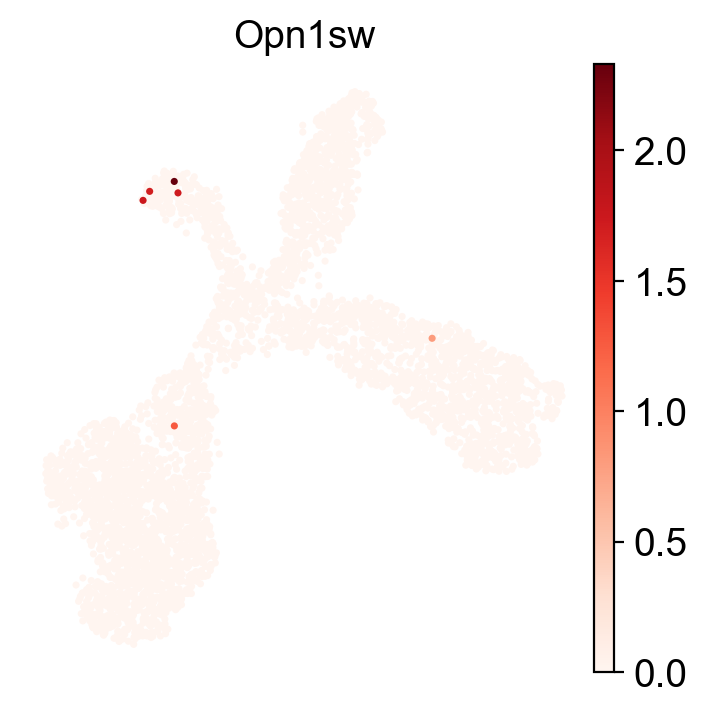

RGC


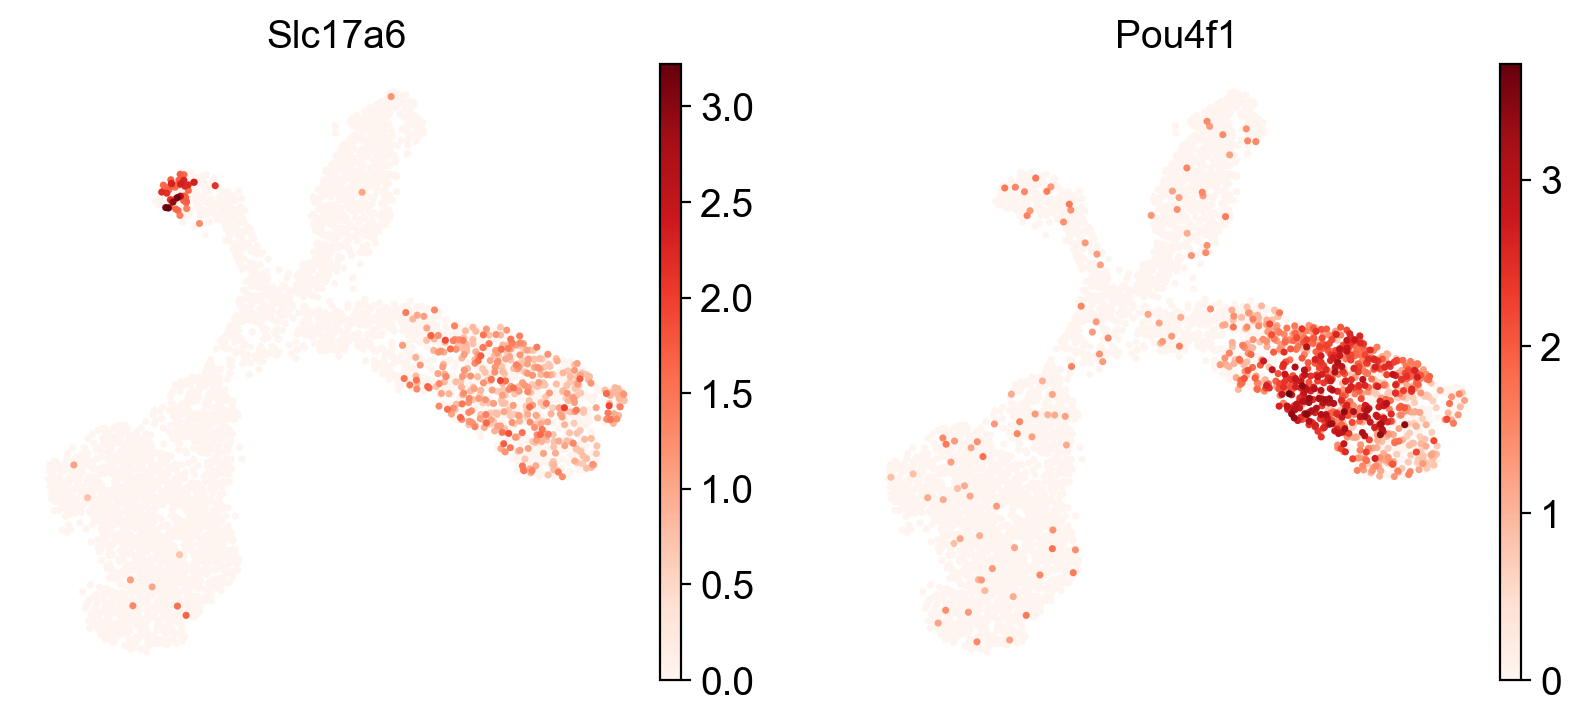

Muller cell


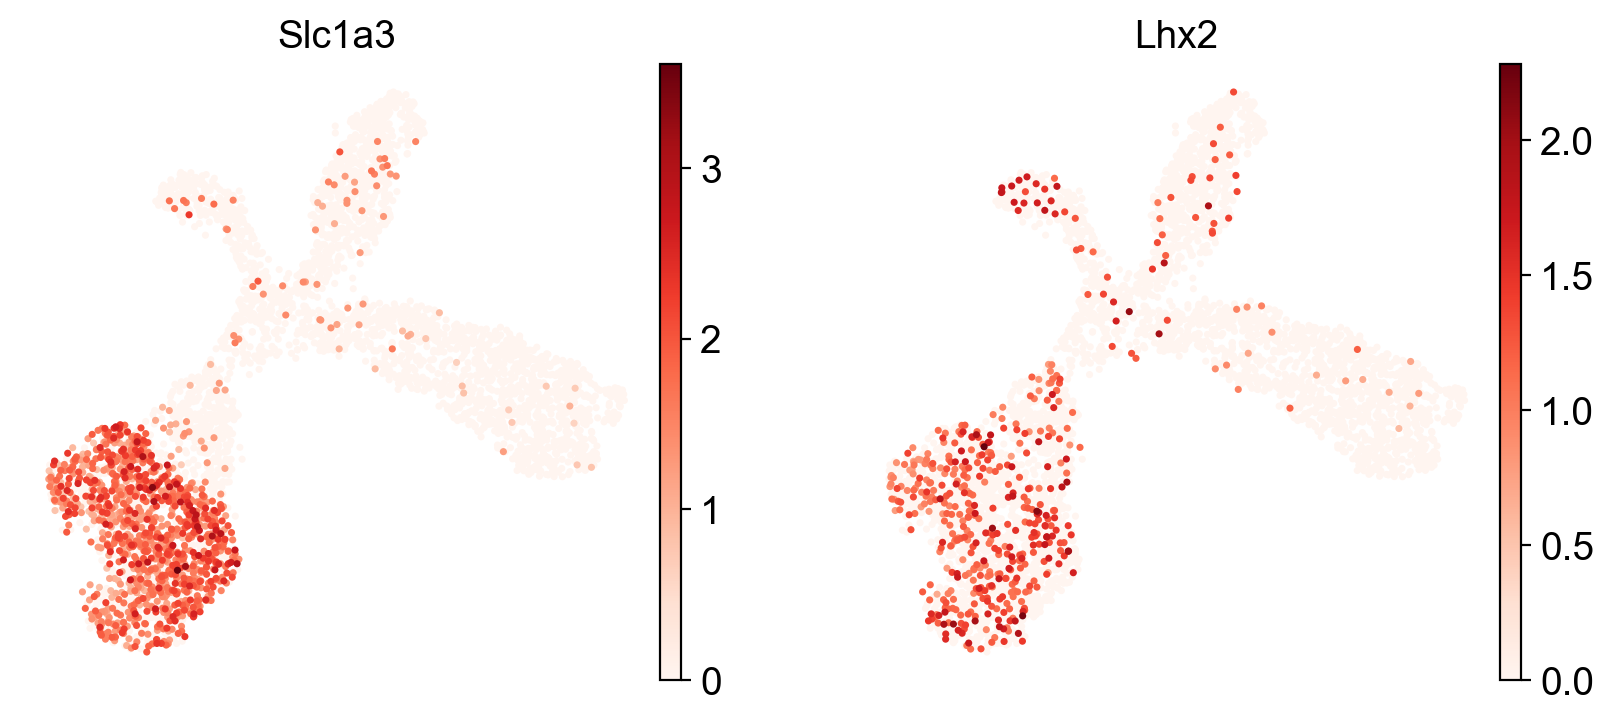

In [6]:
for celltype in my_markers.keys():
    print(celltype)
    sc.pl.umap(adata, color=my_markers[celltype], vmin=0, frameon=False, cmap='Reds')

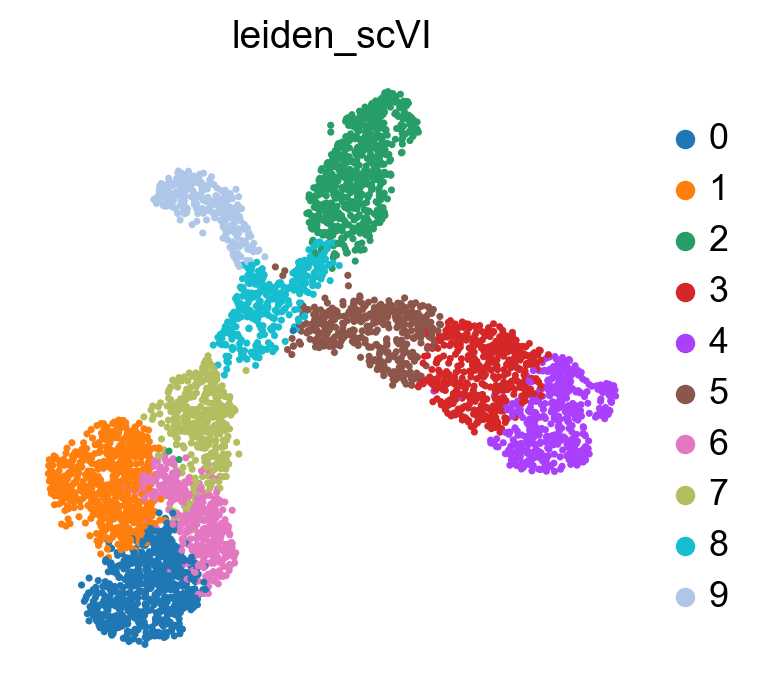

In [7]:
sc.pl.umap(adata, color=['leiden_scVI'], frameon=False)

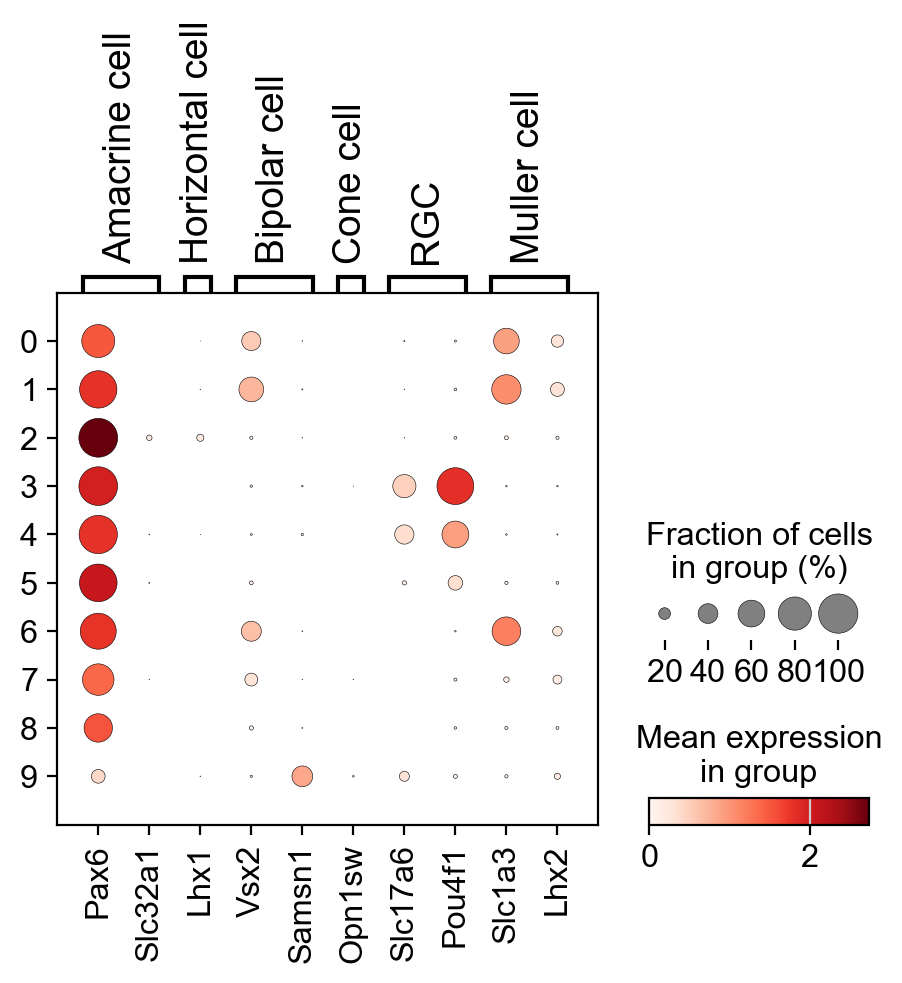

In [8]:
sc.pl.dotplot(adata,
              groupby='leiden_scVI',
              var_names=my_markers)

In [9]:
my_estimate = {
    '2':'Amacrine',
    '9':'Bipolar',
    '3':'RGC',
    '0':'Muller',
    '1':'Muller',
    '6':'Muller'}

In [10]:
adata.obs['Manual_annotation'] = adata.obs['leiden_scVI'].map(my_estimate)

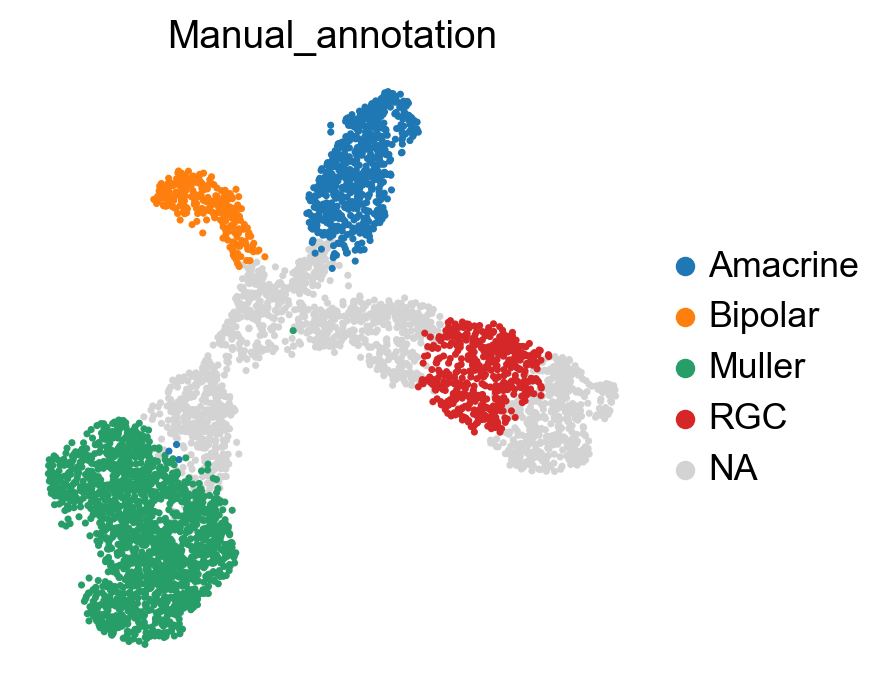

In [11]:
sc.pl.umap(adata, color=['Manual_annotation'], frameon=False)

### 自動アノテーション

[CellAssign](https://doi.org/10.1038/s41592-019-0529-1)によるCell typeの自動推定。

Zhang, A.W., O’Flanagan, C., Chavez, E.A. et al. Probabilistic cell-type assignment of single-cell RNA-seq for tumor microenvironment profiling. Nat Methods 16, 1007–1015 (2019).

CellAssignは、事前知識としてCell typeの種類と、そのCell typeを識別するマーカー遺伝子の組み合わせの情報を使って、それぞれの細胞がいずれのCell typeに割り当てられるのか（あるいは"unassigned"か）の確率分布を計算してくれるツール。

観測された値が、cell type, library size, batchの影響を受けると仮定。

入力は遺伝子のカウントと、マーカー遺伝子・cell typeの対応のテーブル。発現量の閾値などの設定は必要ない。マーカーとcell typeの対応が0/1で表現されていればオーケー。

基本的には、scVIと似たような負の二項分布のモデリング。バッチIDやライブラリサイズを取り込んで、細胞ごとにcell typeを表す潜在変数の確率分布をEMアルゴリズムで最尤推定する。オリジナルのR版はtensorflowで最適化しているが、scvi-toolsに取り込んで実装したバージョンではpytorchを使って最適化。

マーカー遺伝子の情報は、エキスパートの知識で与えるか、[CellMarker](http://xteam.xbio.top/CellMarker/)、[PanglaoDB](https://panglaodb.se)など、マーカー遺伝子のデータベースからとってきて用意する。

ここでは、CellMakerからダウンロードしたマウスのマーカー遺伝子全情報をまとめたエクセルファイルをダウンロードして、該当する組織（眼球・脳・胚）とアノテーションしたいCell typeに対応する遺伝子のリストを抽出し、0/1のテーブルにまとめている。エクセルファイルのサイズがでかいので講習では割愛。すでに処理済みの`eye_markers.csv`のテーブルを配布している。

In [ ]:
%%script true
target_labels = ['Amacrine cell', 
                 'Cone photoreceptor cell',
                 'Horizontal cell',
                 'Late activated neural stem cell',
                 'Late neuroblast',
                 'Neural progenitor cell',
                 'Neuroblast',
                 'Photoreceptor cell',
                 'Retinal ganglion cell',
                 'Retinal progenitor cell']

all_markers = pd.read_excel('./models/marker_genes/Cell_marker_Mouse.xlsx')
eye_markers = all_markers[(all_markers['tissue_class'] == 'Eye') | \
                          (all_markers['tissue_class'] == 'Brain') | \
                          (all_markers['tissue_class'] == 'Embryo')]
eye_markers = eye_markers[['Symbol', 'cell_name']]
eye_markers = eye_markers[eye_markers['cell_name'].isin(target_labels)]
eye_markers['dummy'] = [1]*len(eye_markers)
eye_markers = eye_markers.dropna()
eye_markers = eye_markers.drop_duplicates(keep='first')
eye_markers = eye_markers.pivot(index='Symbol', columns='cell_name', values='dummy')
eye_markers = eye_markers.fillna(0).astype(int)
eye_markers.to_csv('./models/marker_genes/eye_markers.csv')


In [ ]:
eye_markers = pd.read_csv('./models/marker_genes/eye_markers.csv', index_col=0)

以下のように、マーカー遺伝子対Cell typeの対応関係が0/1で表現されている。

In [ ]:
eye_markers.head()

CellAssignはライブラリサイズの情報が計算に必要。ここでは細胞に割り当てられたトータルリード数の、全細胞平均に対する比率で計算することにする。前処理段階で計算した 'total_counts' を流用しているが、カウントデータを使って足し算を計算しなおしてもいい。対数変換した値で足し算しちゃうとスケールが変わっておかしなことになっちゃうので注意。

In [ ]:
adata.obs['size_factor'] = adata.obs['total_counts'].values / adata.obs['total_counts'].values.mean()

マーカー遺伝子のうち、高発現変動遺伝子とオーバーラップするものだけ抽出。（計算速度のため。時間に余裕があれば発現変動遺伝子に限定せず全部のマーカー遺伝子を使ってもいい）

該当のマーカー遺伝子の情報だけ取り出した新しい`anndata`オブジェクトを用意する。

In [ ]:
eye_markers = eye_markers[np.isin(eye_markers.index, adata.var[adata.var['highly_variable'] == True].index)]
bdata = adata[:, eye_markers.index].copy()

モデルのセットアップ。ライブラリサイズやバッチに対応したラベルを指定して、カウントデータが格納されているレイヤーをセットする。

In [ ]:
scvi.external.CellAssign.setup_anndata(bdata, 
    size_factor_key='size_factor',
    batch_key='batch',
    layer='counts')

学習の実行。やはり時間がかかるので講習では学習済みのモデルを配布。

In [ ]:
#cellassign_model = scvi.external.CellAssign(bdata, eye_markers)
#cellassign_model.train()

In [ ]:
#cellassign_model.save('./models/cellassign/', overwrite=True)

In [ ]:
cellassign_model = scvi.external.CellAssign.load('./models/cellassign', bdata)

細胞ごとのcell type確率の予測。

In [ ]:
predictions = cellassign_model.predict()

In [ ]:
predictions

確率最大のcell typeを各細胞に割り当てる。

In [ ]:
bdata.obs['CellAssign_prediction'] = predictions.idxmax(axis=1).values

In [ ]:
bdata.obs

UMAPで見ると以下のようにcell typeが分布している。

In [ ]:
sc.pl.umap(
    bdata,
    color=['leiden_scVI', 'CellAssign_prediction'],
    frameon=False,
    ncols=2
)

精度を上げるには、マーカー遺伝子とアノテーションする細胞型の慎重な選択が必要。（ただそれを突き詰めていくとエキスパートの専門知識でマニュアルアノテーションするのと労力が変わらなくなっていく気もするが）

いっぽうで、クラスタレベルではなく、細胞ひとつひとつの予測が可能な点は強み。数千個の細胞をマニュアルアノテーションするのは大変。

## アトラスとの統合・ラベル転移

マーカー遺伝子を使ったアノテーションがあんまりうまくいってないっぽいので、今度は「リファレンスデータからのラベル転移」でやってみる。

高精度なアノテーションが付与されたシングルセル解析データが大量に蓄積されているアトラスとして、マウスの場合はたとえば[Tabula Muris](https://tabula-muris.ds.czbiohub.org), [Tabula Muris Senis](https://tabula-muris-senis.ds.czbiohub.org)がある。

ただどちらにも欲しい組織（網膜発生プロセス）が欲しい解像度で収載されていない。

ここでは、別の論文のデータを使う。網膜神経系発生について、胚から産後まで10個のタイムポイントで大量の細胞（10万以上）を対象にシングルセル解析したデータ。

Clark, Brian S., et al. "Single-cell RNA-seq analysis of retinal development identifies NFI factors as regulating mitotic exit and late-born cell specification." Neuron 102.6 (2019): 1111-1126.
[https://doi.org/10.1016/j.neuron.2019.04.010](https://doi.org/10.1016/j.neuron.2019.04.010)

この論文の素晴らしいところは、すべての細胞の遺伝子発現カウントデータとcell typeのアノテーションを[公開してくれている](https://github.com/gofflab/developing_mouse_retina_scRNASeq)ところ。

マウス網膜神経発生アトラスといって差し支えないこのデータを活用して、ここまで扱ってきたデータとの統合解析を実行し、アトラスに付与されたcell typeアノテーションをラベル転移（Label transfer）する。

ラベル転移の半教師あり学習には [scANVI](https://docs.scvi-tools.org/en/stable/user_guide/models/scanvi.html#ref1) を使う。確率モデルの詳細は以下の論文を参照。

Xu, Chenling, et al. "Probabilistic harmonization and annotation of single‐cell transcriptomics data with deep generative models." Molecular systems biology 17.1 (2021): e9620. [https://doi.org/10.15252/msb.20209620](https://doi.org/10.15252/msb.20209620)

scANVIはscvi-toolsにモデルのひとつとして実装されている。

めっちゃデカいファイルで、GPU使わない場合は学習にも時間かかるので、データ読み込みと学習については講習では全部スキップ。学習されたモデルからラベルを予測した結果だけcsvファイルで配布する。

リファレンスデータの読み込み。マトリックス、遺伝子メタデータ、細胞メタデータがそれぞれ個別にファイルとして置いてあるので、それぞれ読み込んでひとつのanndataに統合する。

In [ ]:
%%script true
mtx = sc.read_mtx('./ref_data/10x_mouse_retina_development.mtx')
refdata = mtx.transpose()
refdata.obs = pd.read_csv('./ref_data/10x_Mouse_retina_pData_umap2_CellType_annot_w_horiz.csv')
refdata.obs = refdata.obs.set_index('barcode')
refdata.var = pd.read_csv('./ref_data/10x_mouse_retina_development_feature.csv')
refdata.var = refdata.var.set_index('gene_short_name')

リファレンスデータのUMAP座標は計算済みのやつが細胞メタデータに記載されているので、`scanpy.pl.umap`で自動で読み込めるように、`obsm`の中に入れておく。このリファレンスデータの全体像がさくっと確認できる。

In [ ]:
%%script true
refdata.obsm['X_umap'] = refdata.obs[['umap_coord1', 'umap_coord2']].values
sc.pl.umap(refdata, 
           color='umap2_CellType',
           frameon=False)

クエリデータ（ここまで扱ってきたデータ）を **カウントデータ** として用意する。scANVIはscVIと同様、カウントデータを学習する確率モデルであるため。別レイヤーに取っておいたカウントのデータから新しいanndataを作る。

リファレンスデータは 'sample' のラベルのところに別々のタイムポイントからとったサンプルのラベルが記載されている。これをバッチと捉えてバッチ補正を行いたいので、クエリ側のバッチラベル（"E2", "F2"）もここに記述しておく。

In [ ]:
%%script true
from anndata import AnnData
query = AnnData(X=adata.layers['counts'], obs=adata.obs, var=adata.var)
query.obs['sample'] = query.obs['batch']

リファレンスとクエリのデータをひとつのanndataにまとめる。

In [ ]:
%%script true
refdata.var_names_make_unique()
alldata = refdata.concatenate(query)

前半でやったのと同じような、シングルセル解析の前処理をデータ全体に対して実行する。

In [ ]:
%%script true
alldata.layers['counts'] = alldata.X.copy()
sc.pp.normalize_per_cell(alldata, counts_per_cell_after=1e4)
sc.pp.log1p(alldata)
alldata.raw = alldata

In [ ]:
%%script true
sc.pp.highly_variable_genes(alldata, n_top_genes=2000, flavor='seurat')

scVIを利用してデータ全体のバッチ補正を行う統合モデルを学習する。CPUで学習する場合は時間かかるので昼食でもとりにいく。帰ってきたら学習終わってる、くらいの計算時間で済むはず。

In [ ]:
#scvi.model.SCVI.setup_anndata(alldata, layer='counts', batch_key='sample')

In [ ]:
#integration_model = scvi.model.SCVI(alldata)
#integration_model.train()

In [ ]:
#integration_model.save('./models/integration_model')

In [ ]:
#integration_model = scvi.model.SCVI.load('./models/integration_model', alldata)

リファレンス側のデータでcell typeが記述されているカラム（'umap2_CellType'）が、クエリ側のデータでは現在 NaN になっているので、ここを全部 'Unknown' にセットしておく。

In [ ]:
#alldata.obs['umap2_CellType'] = alldata.obs['umap2_CellType'].cat.add_categories('Unknown')
#alldata.obs = alldata.obs.fillna({'umap2_CellType':'Unknown'})

統合モデル、統合データ、未知ラベルのカラムと名前を指定してscANVIモデルをセットアップする。

In [ ]:
%%script true
label_model = scvi.model.SCANVI.from_scvi_model(integration_model,
                                                adata=alldata,
                                                unlabeled_category='Unknown',
                                                labels_key='umap2_CellType')

ラベル転移の学習を実行する。ここはそれほど計算時間かからない（ようにパラメータを設定しているが精度はじゅうぶん出る）

In [ ]:
#label_model.train(n_samples_per_label=100)
#label_model.save('./models/label_transfer')

In [ ]:
#label_model = scvi.model.SCANVI.load('./models/label_transfer/', alldata)

学習されたモデルでcell typeの予測を実行する。

In [ ]:
# predict関数で、soft=Trueとすれば、最大確率のラベルだけでなく、それぞれのラベルの確率値をちゃんと出してくれる
#alldata.obs['predicted_celltype'] = label_model.predict(alldata)

この予測結果全体からクエリ側に対応するデータだけ抜き出して、以下のようにcsvとして保存したのが配布しているデータ。

In [ ]:
#predictions = alldata.obs[(alldata.obs['sample'] == 'E2') | (alldata.obs['sample'] == 'F2')]['predicted_celltype']
#predictions.index = predictions.index.str[:-2]
#predictions.to_csv('./models/label_transfer/celltype_predictions.csv')

csvファイルをロード。

In [ ]:
predictions = pd.read_csv('./models/label_transfer/celltype_predictions.csv', index_col=0)

In [ ]:
predictions

adataに予測されたラベルを格納。

In [ ]:
adata.obs['predicted_celltype'] = predictions.loc[adata.obs.index, 'predicted_celltype']

予測されたラベルの細胞数カウントは以下。それっぽいラベルが並んでいる。

In [ ]:
adata.obs['predicted_celltype'].value_counts()

以下が予測結果で色分けしたUMAP。

RPCs は Retinal Progenitor Cells の略。

RPCs からNeurogenicにつながって、Photoreceptor/Conesに分岐していく流れと、Amacrine/Horizontalに分岐していく流れと、Retinal ganglion cellsに分岐する3つの流れに分かれていることがわかった。

In [ ]:
sc.pl.umap(adata,
    color=['leiden_scVI', 'predicted_celltype'],
    frameon=False, alpha=0.5,
    ncols=2)

Leidenクラスタに名前をつけたいので、それぞれのクラスタに所属している細胞がどのcell typeラベルを持っているのか、数をクロス集計してみる。

In [ ]:
pd.crosstab(adata.obs['leiden_scVI'], adata.obs['predicted_celltype'])

このカウントを元に、多数決で以下のような適当な名前をつけた。

In [ ]:
leiden_to_celltypes = {
    '0':'Early-RPCs', '1':'Late-RPCs-1',
    '2':'Amacrine/Horizontal-Cells', '3':'RGCs-1', '4':'RGCs-2',
    '5':'RGCs-3', '6':'Late-RPCs-2',
    '7':'Neurogenic-1',
    '8':'Neurogenic-2',
    '9':'Cones/Photoreceptor-Precursors'}

adata.obs['leiden_celltypes'] = [leiden_to_celltypes[v] for v in adata.obs['leiden_scVI'].values]

名前がついたLeidenクラスタを可視化してみる。

In [ ]:
with plt.rc_context({"figure.figsize": (9, 9)}):
    sc.pl.umap(adata,
        color='leiden_celltypes',
        legend_fontsize=10,
        frameon=False, alpha=0.5,
        legend_loc='on data')

## RNA速度の推定

### 事前準備（velocyto）

scVeloを使うためには、spliced/unsplicedの二種類のカウントデータが必要となる。

なので事前に [velocyto](http://velocyto.org/velocyto.py/index.html) を使って、Cell Rangerが生成したゲノムマッピングのBAMファイルから、spliced/unsplicedのカウントデータを作っておく。

バッチごとに実行して、それぞれのバッチに属する細胞のspliced/unsplicedカウントを格納した [loom](https://linnarssonlab.org/loompy/index.html) データを作る。

計算に時間がかかるので、講習ではすでにvelocyto計算済みの結果を配布している。

velocytoは以下のコマンドで実行する。

```bash
velocyto run10x \
    -m /path/to/Cell_Ranger_References/mm10_rmsk.gtf \
    /path/to/RetinalBatchE2 \
    /path/to/Cell_Ranger_References/refdata-gex-mm10-2020-A/genes/genes.gtf

velocyto run10x \
    -m /path/to/Cell_Ranger_References/mm10_rmsk.gtf \
    /path/to/RetinalBatchF2 \
    /path/to/Cell_Ranger_References/refdata-gex-mm10-2020-A/genes/genes.gtf
```

velocytoでバッチごとに推定したloomファイルを統合して書き出す。ここの統合処理も時間かかるので、統合後のデータを配布。

In [ ]:
%%script true
import loompy
loompy.combine(['./data/RetinalBatchE2/velocyto/RetinalBatchE2.loom',
                './data/RetinalBatchF2/velocyto/RetinalBatchF2.loom'],
               output_file='./data/retinal_velo.loom')

In [ ]:
import scvelo as scv
scv.set_figure_params()

spliced/unsplicedのカウントデータを遺伝子発現テーブルと統合する。細胞のバーコードで紐づけるので、長さの指定（インデックスのどの部分がバーコードか）が必要になることに注意。

In [ ]:
ldata = scv.read('./data/retinal_velo.loom', cache=True)

# id_lengthは細胞を区別するバーコード配列の長さ。事前に確認しておく
# また、scVIのmerge関数は勝手にこれまでのクラスタの色指定をリセットしちゃうので一時退避させて再設定しておく
# 'uns'(unstructured)は特に構造の決まってない雑多なメタデータを格納しておく場所。
cluster_colors = adata.uns['leiden_celltypes_colors']
adata = scv.utils.merge(adata, ldata, id_length=16)
adata.uns['leiden_celltypes_colors'] = cluster_colors

scVeloの関数で、遺伝子ごとのspliced/unsplicedカウントの比率を表示できる。実験プラットフォームにもよるが、だいたいunsplicedが25%程度らしい。クラスタごとにも表示。極端にunsplicedがとれてないクラスタがあるかどうかチェックする。

In [ ]:
scv.pl.proportions(adata, groupby='leiden_celltypes')

速度計算を実行する。近傍グラフの構成から。

In [ ]:
# scVI補完の潜在空間上で近傍グラフ構成、一次・二次モーメント計算
scv.pp.moments(adata, use_rep='X_scVI')

Splicing kineticsモデルのパラメータ推論。

"Steady-state"モデル。

In [ ]:
scv.tl.velocity(adata, mode='deterministic')

速度ベクトルを元に、細胞から細胞への遷移確率を計算。

In [ ]:
scv.tl.velocity_graph(adata)

速度ベクトルから構成した「流れ」をプロットしてみる。

In [ ]:
scv.pl.velocity_embedding_stream(adata, 
        basis='X_umap', color='leiden_celltypes',
        legend_fontsize=9,
        smooth=0.8, min_mass=4)

Progenitorの集団からはじまって、わかりやすい三分岐。

"EM"モデル。

In [ ]:
scv.tl.recover_dynamics(adata, n_jobs=8)
scv.tl.recover_latent_time(
    adata,
    root_key='initial_states_probs', 
    end_key='terminal_states_probs')

「膨らみ方」（splicing kinetics）は遺伝子ごとに異なる。scVeloのscatter関数では遺伝子ごとに、具体的にどのようなダイナミクスが推定されたのかプロットしてくれる。それぞれの遺伝子がそれぞれ異なるタイミング、異なるパターンで、induction => steady-state => repressionのパスを巡っている。

In [ ]:
top_genes = adata.var["fit_likelihood"].sort_values(ascending=False).index
scv.pl.scatter(adata, basis=top_genes[:5], color="leiden_celltypes", frameon=False)

In [ ]:
scv.tl.velocity(adata, mode="dynamical")
scv.tl.velocity_graph(adata, n_jobs=8)

In [ ]:
scv.pl.velocity_embedding_stream(adata, 
        basis='X_umap', color='leiden_celltypes',
        legend_fontsize=9,
        smooth=0.8, min_mass=4)

RNA速度を計算することによって、トランスクリプトームパターンの幾何学的な近接性だけで推定された 'Pseudo time' ではなく、速度情報をちゃんと織り込んだ細胞の 'Latent time' を計算できる。

In [ ]:
scv.pl.scatter(
    adata,
    color=['leiden_celltypes', 'latent_time'],
    fontsize=16,
    cmap='viridis',
    perc=[2, 98],
    colorbar=True,
    rescale_color=[0, 1],
    title=['clusters', 'latent time'])

Progenitorの部分がごちゃごちゃしてわかりにくいので、取り出して個別に解析してみる。

どうもグルグルとまわってるみたいなので、細胞周期のマーカー遺伝子発現をチェック。

In [ ]:
prog = adata[adata.obs['leiden_celltypes'].isin(['Early-RPCs', 'Late-RPCs-1', 'Late-RPCs-2'])].copy()

In [ ]:
sc.pp.neighbors(prog, use_rep="X_scVI", n_neighbors=50)
sc.tl.umap(prog, min_dist=2.0)
sc.pl.umap(prog, 
           ncols=2,
           color=['Mcm6', 'Esco2', 'Top2a', 'Aurka', 'Cenpa'],
           cmap='viridis',
           frameon=False)

というわけで、このグルグルは細胞周期を反映しているのだった。

この中だけで速度を描くとよりわかりやすい。

In [ ]:
scv.pp.moments(prog, use_rep='X_scVI')
scv.tl.recover_dynamics(prog, n_jobs=8)
scv.tl.velocity(prog, mode="dynamical")
scv.tl.velocity_graph(prog)
scv.pl.velocity_embedding_stream(prog, 
    basis='X_umap', color='leiden_celltypes',
    smooth=0.8, min_mass=4)

細かく見ると印象が違ってくることもあるので、流れの全体像として粗視化されたパターンだけでなく、それぞれの速度をつぶさに見ていくことも大事。

In [ ]:
scv.pl.velocity_embedding(adata, figsize=(9, 9),
        basis='X_umap', color='leiden_celltypes',
        scale=0.5)